In [ ]:
!pip3 uninstall cupy-cuda101
!pip3 install cupy-cuda101

Uninstalling cupy-cuda101-7.4.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cupy/*
    /usr/local/lib/python3.6/dist-packages/cupy_cuda101-7.4.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/cupyx/*
Proceed (y/n)? y
  Successfully uninstalled cupy-cuda101-7.4.0
     |█████████████████████████████▉  | 107.3MB 1.3MB/s eta 0:00:07

In [ ]:
!git clone https://github.com/hsha0/laneDetection
%cd laneDetection/
!mkdir Results

Cloning into 'laneDetection'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 155 (delta 79), reused 114 (delta 42), pack-reused 0
Receiving objects: 100% (155/155), 1.23 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/laneDetection/laneDetection/laneDetection


In [ ]:
!python3 canny_edge.py 1.jpg

In [ ]:
import cupy as cp
import numpy as np

def interp2(v, xq, yq):
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = cp.floor(xq).astype(cp.int32)
	y_floor = cp.floor(yq).astype(cp.int32)
	x_ceil = cp.ceil(xq).astype(cp.int32)
	y_ceil = cp.ceil(yq).astype(cp.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

In [ ]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import os
import sys
from cupyx.scipy import signal
from PIL import Image
import argparse
import cv2

# import functions
# from helpers import interp2

"""# Tests and Visualization"""
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    return test_pass

'''
  Derivatives visualzation function
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = cp.histogram(Mag_vec.transpose(), 100)

    ind_array = cp.array(cp.where( (cp.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = cp.where(cp.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = cp.meshgrid(cp.arange(0, Mag.shape[1], 1), cp.arange(0, Mag.shape[0], 1))
    Ori = cp.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )
    


'''
  Edge detection result visualization function
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

"""# Functions"""

'''
  Convert RGB image to gray one manually
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    # TODO: complete function
    dx = cp.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=np.float)
    dy = cp.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float)
    G = cp.array([[2, 4, 5, 4, 2],
                  [4, 9, 12, 9, 4],
                  [5, 12, 15, 12, 5],
                  [4, 9, 12, 9, 4],
                  [2, 4, 5, 4, 2]], dtype=np.float) / 159.0

    # compute G convolve dx and dy respectively
    G_dx = signal.convolve2d(G, dx, mode='same')
    G_dy = signal.convolve2d(G, dy, mode='same')
    # compute Magx and Magy
    Magx = signal.convolve2d(I_gray, G_dx, mode='same')
    Magy = signal.convolve2d(I_gray, G_dy, mode='same')

    # compute Mag and Ori
    Mag = cp.sqrt(Magx ** 2 + Magy ** 2)
    Ori = cp.arctan2(Magy, Magx)
    return Mag, Magx, Magy, Ori

def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the magnitude of derivatives
        - Input Ori: H x W matrix represents the orientation of derivatives
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    # get number of columns and rows
    nc, nr = Mag.shape[1], Mag.shape[0]
    # build meshgrid
    x, y = cp.meshgrid(cp.arange(nc), cp.arange(nr))

    # find x, y for neighbor in positive gradient orientation
    positive_neighbor_x = x + cp.cos(Ori)
    positive_neighbor_y = y + cp.sin(Ori)

    # find x, y for neighbor in negative gradient orientation
    negative_neighbor_x = x - cp.cos(Ori)
    negative_neighbor_y = y - cp.sin(Ori)

    # get Mag of neighbors in positive gradient orientation
    # and replace edge cases with 0
    positive_neighbors = interp2(Mag, positive_neighbor_x, positive_neighbor_y)
    edge_mask = cp.logical_and(cp.where((positive_neighbor_x > nc-1) | (positive_neighbor_x < 0), 0, 1), \
                               cp.where((positive_neighbor_y > nr-1)|(positive_neighbor_y < 0), 0, 1))
    positive_neighbors *= edge_mask

    # get Mag of neighbors in negative gradient orientation
    # and replace edge cases with 0
    negative_neighbors = interp2(Mag, negative_neighbor_x, negative_neighbor_y)
    edge_mask = cp.logical_and(cp.where((negative_neighbor_x < 0) | (negative_neighbor_x > nc-1), 0, 1), \
                               cp.where((negative_neighbor_y < 0) | (negative_neighbor_y > nr-1), 0, 1))
    negative_neighbors *= edge_mask
    
    # compare current Mag with its positive and negative neighbors
    NMS = cp.logical_and(Mag > positive_neighbors, Mag > negative_neighbors)
    return NMS

def edgeLink(M, Mag, Ori, low, high):
    '''
    File clarification:
        Use hysteresis to link edges based on high and low magnitude thresholds
        - Input M: H x W logical map after non-max suppression
        - Input Mag: H x W matrix represents the magnitude of gradient
        - Input Ori: H x W matrix represents the orientation of gradient
        - Input low, high: low and high thresholds 
        - Output E: H x W binary matrix represents the final canny edge detection map
    '''
    # get number of columns and rows
    # build meshgrid
    nc, nr = Mag.shape[1], Mag.shape[0]
    x, y = cp.meshgrid(cp.arange(nc), cp.arange(nr))

    # suppress pixels whose magnitude is lower than low threshold
    weak_mask = cp.where(Mag > low, 1, 0)
    Mag = Mag * weak_mask * M
    # initial EdgeMap with strong edges
    strong_mask = cp.where(Mag > high, 1, 0)
    edge_map = M * strong_mask
    # compute the edge direction from Ori
    edge_ori = Ori + cp.pi/2
    # find neighbors in the edge direction
    positive_neighbor_x = x + cp.cos(edge_ori)
    positive_neighbor_y = y + cp.sin(edge_ori)

    negative_neighbor_x = x - cp.cos(edge_ori)
    negative_neighbor_y = y - cp.sin(edge_ori)
    prev = cp.zeros([nr, nc])
    # try to link weak edges to strong edges until there is no change
    while (not cp.allclose(prev, edge_map)):
      # get Mag of neighbor in positive edge orientation
      # and deal with out of boundary cases
      positive_neighbors = interp2(Mag, positive_neighbor_x, positive_neighbor_y)
      edge_mask = cp.logical_and(cp.where((positive_neighbor_x > nc-1) | (positive_neighbor_x < 0), 0, 1), \
                               cp.where((positive_neighbor_y > nr-1)|(positive_neighbor_y
                                                                                                                                                 < 0), 0, 1))
      positive_neighbors *= edge_mask
      # get Mag of neighbor in negative edge orientation
      # and deal with out of boundary cases
      negative_neighbors = interp2(Mag, negative_neighbor_x, negative_neighbor_y)
      edge_mask = cp.logical_and(cp.where((negative_neighbor_x < 0) | (negative_neighbor_x > nc-1), 0, 1), \
                               cp.where((negative_neighbor_y < 0) | (negative_neighbor_y > nr-1), 0, 1))
      negative_neighbors *= edge_mask

      # find new edge points and suppress invalid ones (not in M or not in weak edges)
      new_edge_points = cp.logical_or(cp.where(positive_neighbors > high, 1, 0), \
                                      cp.where(negative_neighbors > high, 1, 0)) * weak_mask * M
      # update Mag values for new edge points
      Mag += new_edge_points * 20
      # update prev edge map
      prev = edge_map
      # update cur edge map
      edge_map = cp.logical_or(edge_map, new_edge_points)
    
    return cp.asarray(edge_map, dtype=bool)

def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)

    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)

    # only when test passed that can show all results
    # if Test_script(im_gray, E):
        # visualization results
        # visDerivatives(im_gray, Mag, Magx, Magy)
        # visCannyEdge(I, M, E)

        # plt.show()

    return E




In [68]:
def crop_image(img, vertices):
    # crop the image except the lower part that contains the edges
    mask = np.zeros((img.shape[0], img.shape[1]))
    cv2.fillPoly(mask, [vertices], 1)
    masked_img = np.multiply(img, mask)
    return masked_img

In [122]:
def hough_transform(cropped_img, original_img):
    # apply hough transform to determine two straight edges
    edge = cv2.HoughLinesP(cropped_img, rho=5, theta=np.pi/60, threshold=180, lines=np.array([]), minLineLength=40, maxLineGap=40)
    # edge = cv2.HoughLines(cropped_img, rho=6, theta=np.pi/60, threshold=160, lines=np.array([]))
    hough_img = np.zeros((cropped_img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_edge_x = []
    left_edge_y = []
    right_edge_x = []
    right_edge_y = []
    for i in edge:
        for x1, y1, x2, y2 in i:
            slope = (y2 - y1)/(x2 - x1)
            if (slope <= 0):
                left_edge_x.extend([x1, x2])
                left_edge_y.extend([y1, y2])
            else:
                right_edge_x.extend([x1, x2])
                right_edge_y.extend([y1, y2])
    # fit the left edges and right edges to get single left and right edge
    poly_left = np.poly1d(np.polyfit(left_edge_y, left_edge_x, deg=1))
    poly_right = np.poly1d(np.polyfit(right_edge_y, right_edge_x, deg=1))
    y_bot = int(cropped_image.shape[0] - 1)
    y_top = int(cropped_image.shape[0] / 3 - 1)
    x_left_bot = int(poly_left(y_bot))
    x_left_top = int(poly_left(y_top))
    x_right_bot = int(poly_right(y_bot))
    x_right_top = int(poly_right(y_top))
    # cv2.line(hough_img, (x1, y1), (x2, y2), [255, 0, 0], 4)
    # draw the left and right edge on the image
    cv2.line(hough_img, (x_left_bot, y_bot), (x_left_top, y_top), [255, 0, 0], 4)
    cv2.line(hough_img, (x_right_bot, y_bot), (x_right_top, y_top), [255, 0, 0], 4)
    combine_img = cv2.addWeighted(original_img, 1.0, hough_img, 1.0, 0.0)
    return combine_img

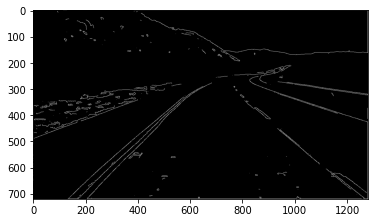

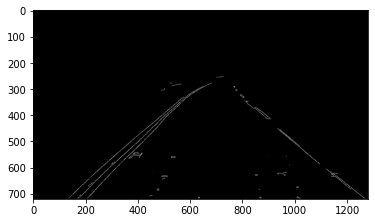

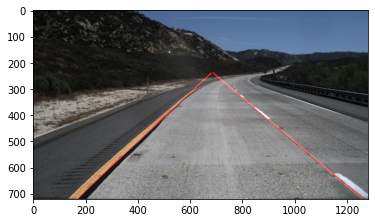

In [127]:
# tuning threshold for simple test images
image_folder = "/content/laneDetection/Test_Images"
save_folder = "/content/laneDetection/Results" # need to create this folder in the drive
filename= "1.jpg" #sys.argv[1] # TODO: change image name
I = cp.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
I1 = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 40, 100
E = cannyEdge(I, low, high)
# pil_image = Image.fromarray(cp.asnumpy(E.astype(cp.uint8)) * 255).convert('L')
pil_image = cp.asnumpy(E.astype(cp.uint8)) * 255
# check the result in the folder
# pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

# crop the image
vertices = np.array([[0, pil_image.shape[0] - 2], [pil_image.shape[1] / 2 - 1, pil_image.shape[0] / 4 - 1], [pil_image.shape[1] - 2, pil_image.shape[0] - 2]], np.int32)
cropped_image = crop_image(pil_image, vertices)

# implement hough transform
hough_image = hough_transform(cropped_image.astype(np.uint8), I1)

# show the image
plt.figure()
plt.imshow(pil_image, cmap='gray')

plt.show()

plt.figure()
plt.imshow(cropped_image, cmap='gray')

plt.show()

plt.figure()
plt.imshow(hough_image, cmap='gray')

plt.show()
